In [ ]:
!pip install langgraph
!pip install langchain
!pip install langchain_groq

In [15]:
from langchain_groq import ChatGroq
from langgraph.graph import StateGraph
from langgraph.prebuilt import create_react_agent
import os
from typing_extensions import TypedDict
from langchain.tools import Tool
from typing import List
from langchain_core.messages import HumanMessage
from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages
from langgraph.graph import START ,END

In [19]:
class AgentState(TypedDict):
  messages:List[HumanMessage]

llm=ChatGroq(model_name="llama-3.1-8b-instant" , api_key=GROQ_API_KEY)


def react_agent(state:AgentState) -> AgentState:
  responce=llm.invoke(state['messages'])
  print(f"AI responce: {responce.content}")
  return state


graph=StateGraph(AgentState)
graph.add_node("agent" , react_agent)
graph.add_edge(START , 'agent')
graph.add_edge('agent', END)

agent=graph.compile()

In [20]:
agent.invoke({"messages":"can u tell me about the america"})

AI responce: The United States of America (USA) is a federal republic composed of 50 states, a federal district, and various territories. The country is known for its diverse geography, vibrant culture, and significant contributions to global politics, economy, and science. Here's a brief overview:

**Geography and Climate:**

- The USA is the 4th largest country by land area, covering approximately 9.8 million square kilometers.
- It borders Canada to the north and Mexico to the south.
- The country has diverse geography, including mountains (Rocky Mountains), deserts (Mojave and Sonoran), forests, and coastlines along the Atlantic, Pacific, and Gulf of Mexico.
- The climate varies from tropical to polar, with regions experiencing hot and dry conditions, cold and snowy, and temperate with moderate temperatures.

**History:**

- The USA declared independence from Great Britain in 1776 and became a sovereign nation.
- The country expanded through the Louisiana Purchase (1803), Mexican-A

{'messages': 'can u tell me about the america'}

In [28]:
from typing import Annotated , List ,TypedDict
from langgraph.graph import START, StateGraph ,END
from langgraph.graph.message import add_messages
from langchain_core.tools import tool
from langchain_core.messages import HumanMessage
from langgraph.prebuilt import ToolNode
from langchain_core.messages import BaseMessage
from langchain_core.messages import ToolMessage
from langgraph.prebuilt import create_react_agent
from langchain_core.messages import SystemMessage
from langgraph.prebuilt import tool_node


In [25]:
from collections.abc import Sequence
class AgentState(TypedDict):
  messages:Annotated[Sequence[BaseMessage] , add_messages]

@tool
def add_num(a:int , b:int):
  """this function return the sum  of the two num"""
  return a+b

@tool
def sub_num(a:int , b:int):
  """this num return the substraction of the two num"""
  return a-b

@tool
def multiply(a: int, b: int):
    """Multiplication function"""
    return a * b
tools=[add_num ,sub_num ,multiply]

llm_with_tools=llm.bind_tools(tools)


In [27]:
def llm_model(state:AgentState) -> AgentState:
  system_prompt=SystemMessage(content="your name is sara u are the buisneess assistant  think and give the answer from them and also used the appropriate tool if needed")
  responce=llm_with_tools.invoke([system_prompt] + state['messages'])
  return {"messages":[responce]}

def should_continue(state:AgentState):
  messages:state['messages']
  last_messages=messages[-1]
  if not last_messages.tool_calls:
    return "end"
  else:
    return "continue"


In [32]:
graph= StateGraph(AgentState)
graph.add_node("our_model" ,llm_model)

tool_node=ToolNode(tools=tools)
graph.add_node("tools" ,tool_node)
graph.set_entry_point("our_model")

graph.add_conditional_edges(
    "our_model",
    should_continue,
    {
        "continue":"tools",
        "end":END

    }
)

graph.add_edge("tools","our_model")

app=graph.compile()

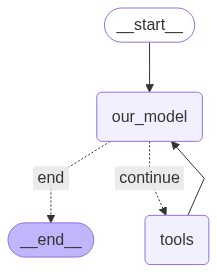

In [33]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [43]:
react_agent=create_react_agent(
    llm,
    tools=tools,
    prompt="first start with the welcome message Hi i am sara ur helping assistant u are the helping assistant give the answer of the question and sue yhe tool",
)

In [44]:
responce=react_agent.invoke({"messages":"who are u"})

In [45]:
print(responce)

{'messages': [HumanMessage(content='who are u', additional_kwargs={}, response_metadata={}, id='ee1812b4-14bf-4bf4-b793-6abc9cf4489f'), AIMessage(content='I am an artificial intelligence model known as Llama. Llama stands for "Large Language Model Meta AI."', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 23, 'prompt_tokens': 379, 'total_tokens': 402, 'completion_time': 0.059512379, 'prompt_time': 0.119889453, 'queue_time': 0.050116348, 'total_time': 0.179401832}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_2a85b31419', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--29f87f7e-ead9-47e7-916a-9a2a297e45b7-0', usage_metadata={'input_tokens': 379, 'output_tokens': 23, 'total_tokens': 402})]}


In [54]:
import operator
from typing import Annotated, TypedDict

from langchain_core.messages import BaseMessage, HumanMessage
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import create_react_agent
from langgraph.checkpoint.memory import InMemorySaver # For memory
from langgraph.prebuilt.tool_node import ToolNode # Import ToolNode

# 1. Define custom tools (optional, but a common use case)
@tool
def send_email(email_address: str, email_content: str) -> str:
    """Sends an email to a specified recipient with the given content."""
    # In a real-world scenario, this would integrate with an email service
    print(f"Sending email to {email_address} with content: {email_content}")
    return f"Email successfully sent to {email_address}"

# 2. Define the agent's state
# The state will primarily track the message history
class AgentState(TypedDict):
    messages: Annotated[list[BaseMessage], operator.add]

# 3. Create the prebuilt ReAct agent
# Requires an LLM and a list of tools
tools = [send_email]

# Create the agent with an optional checkpointer for memory
checkpointer = InMemorySaver()
react_agent = create_react_agent(llm, tools, checkpointer=checkpointer)

# 4. Integrate the ReAct agent into a larger graph (if needed)

#  Define a custom node to encapsulate the ReAct agent
def react_agent_node(state: AgentState):
    return react_agent.invoke({"messages": state["messages"]})

# Build the graph
workflow = StateGraph(AgentState)

# Add the ReAct agent as a node in the graph
workflow.add_node("react_agent", react_agent_node)

# Set the entry point of the graph to the ReAct agent
workflow.set_entry_point("react_agent")

# Define conditional edges: if the ReAct agent performs tool calls, route to tools_condition
# Otherwise, it's the final response, so route to END
workflow.add_conditional_edges(
    "react_agent",
    # tools_condition is a prebuilt LangGraph function that checks for tool calls
    lambda x: "tools" if x["messages"][-1].tool_calls else END,
    {"tools": "tools", END: END}, # Route to the "tools" node or END
)

# Add a ToolNode to handle tool calls
workflow.add_node("tools", ToolNode(tools)) # ToolNode is also prebuilt in LangGraph
workflow.add_edge("tools", "react_agent") # After tool execution, return to the agent

# Compile the graph
app = workflow.compile()

# Example usage with memory
config = {"configurable": {"thread_id": "conversation_1"}}
response = app.invoke(
    {"messages": [HumanMessage(content="Send an email to jane.doe@example.com with the subject 'Meeting Reminder' and the content 'Please remember our meeting tomorrow at 10 AM)")]},
    config=config
)

print(response["messages"][-1].content)



Sending email to jane.doe@example.com with content: Please remember our meeting tomorrow at 10 AM)
However, the subject of the email is currently missing. To include it in the email content, you would need to modify the function call. Unfortunately, the documentation for 'send_email' doesn't provide information on sending the subject separately.


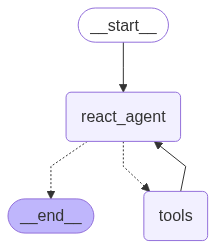

In [55]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))